In [1]:
import pygmt
import numpy as np
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as colours
import os
import requests
import geopandas as gpd
import shapely
import json
import cartopy.crs as ccrs

from aussedthickrf.utils import get_australian_sedimentary_basins


In [2]:
gdf = get_australian_sedimentary_basins()

plot [WARNING]: Long input record (5122 bytes) was truncated to first 4093 bytes!
plot [WARNING]: Long input record (4281 bytes) was truncated to first 4093 bytes!


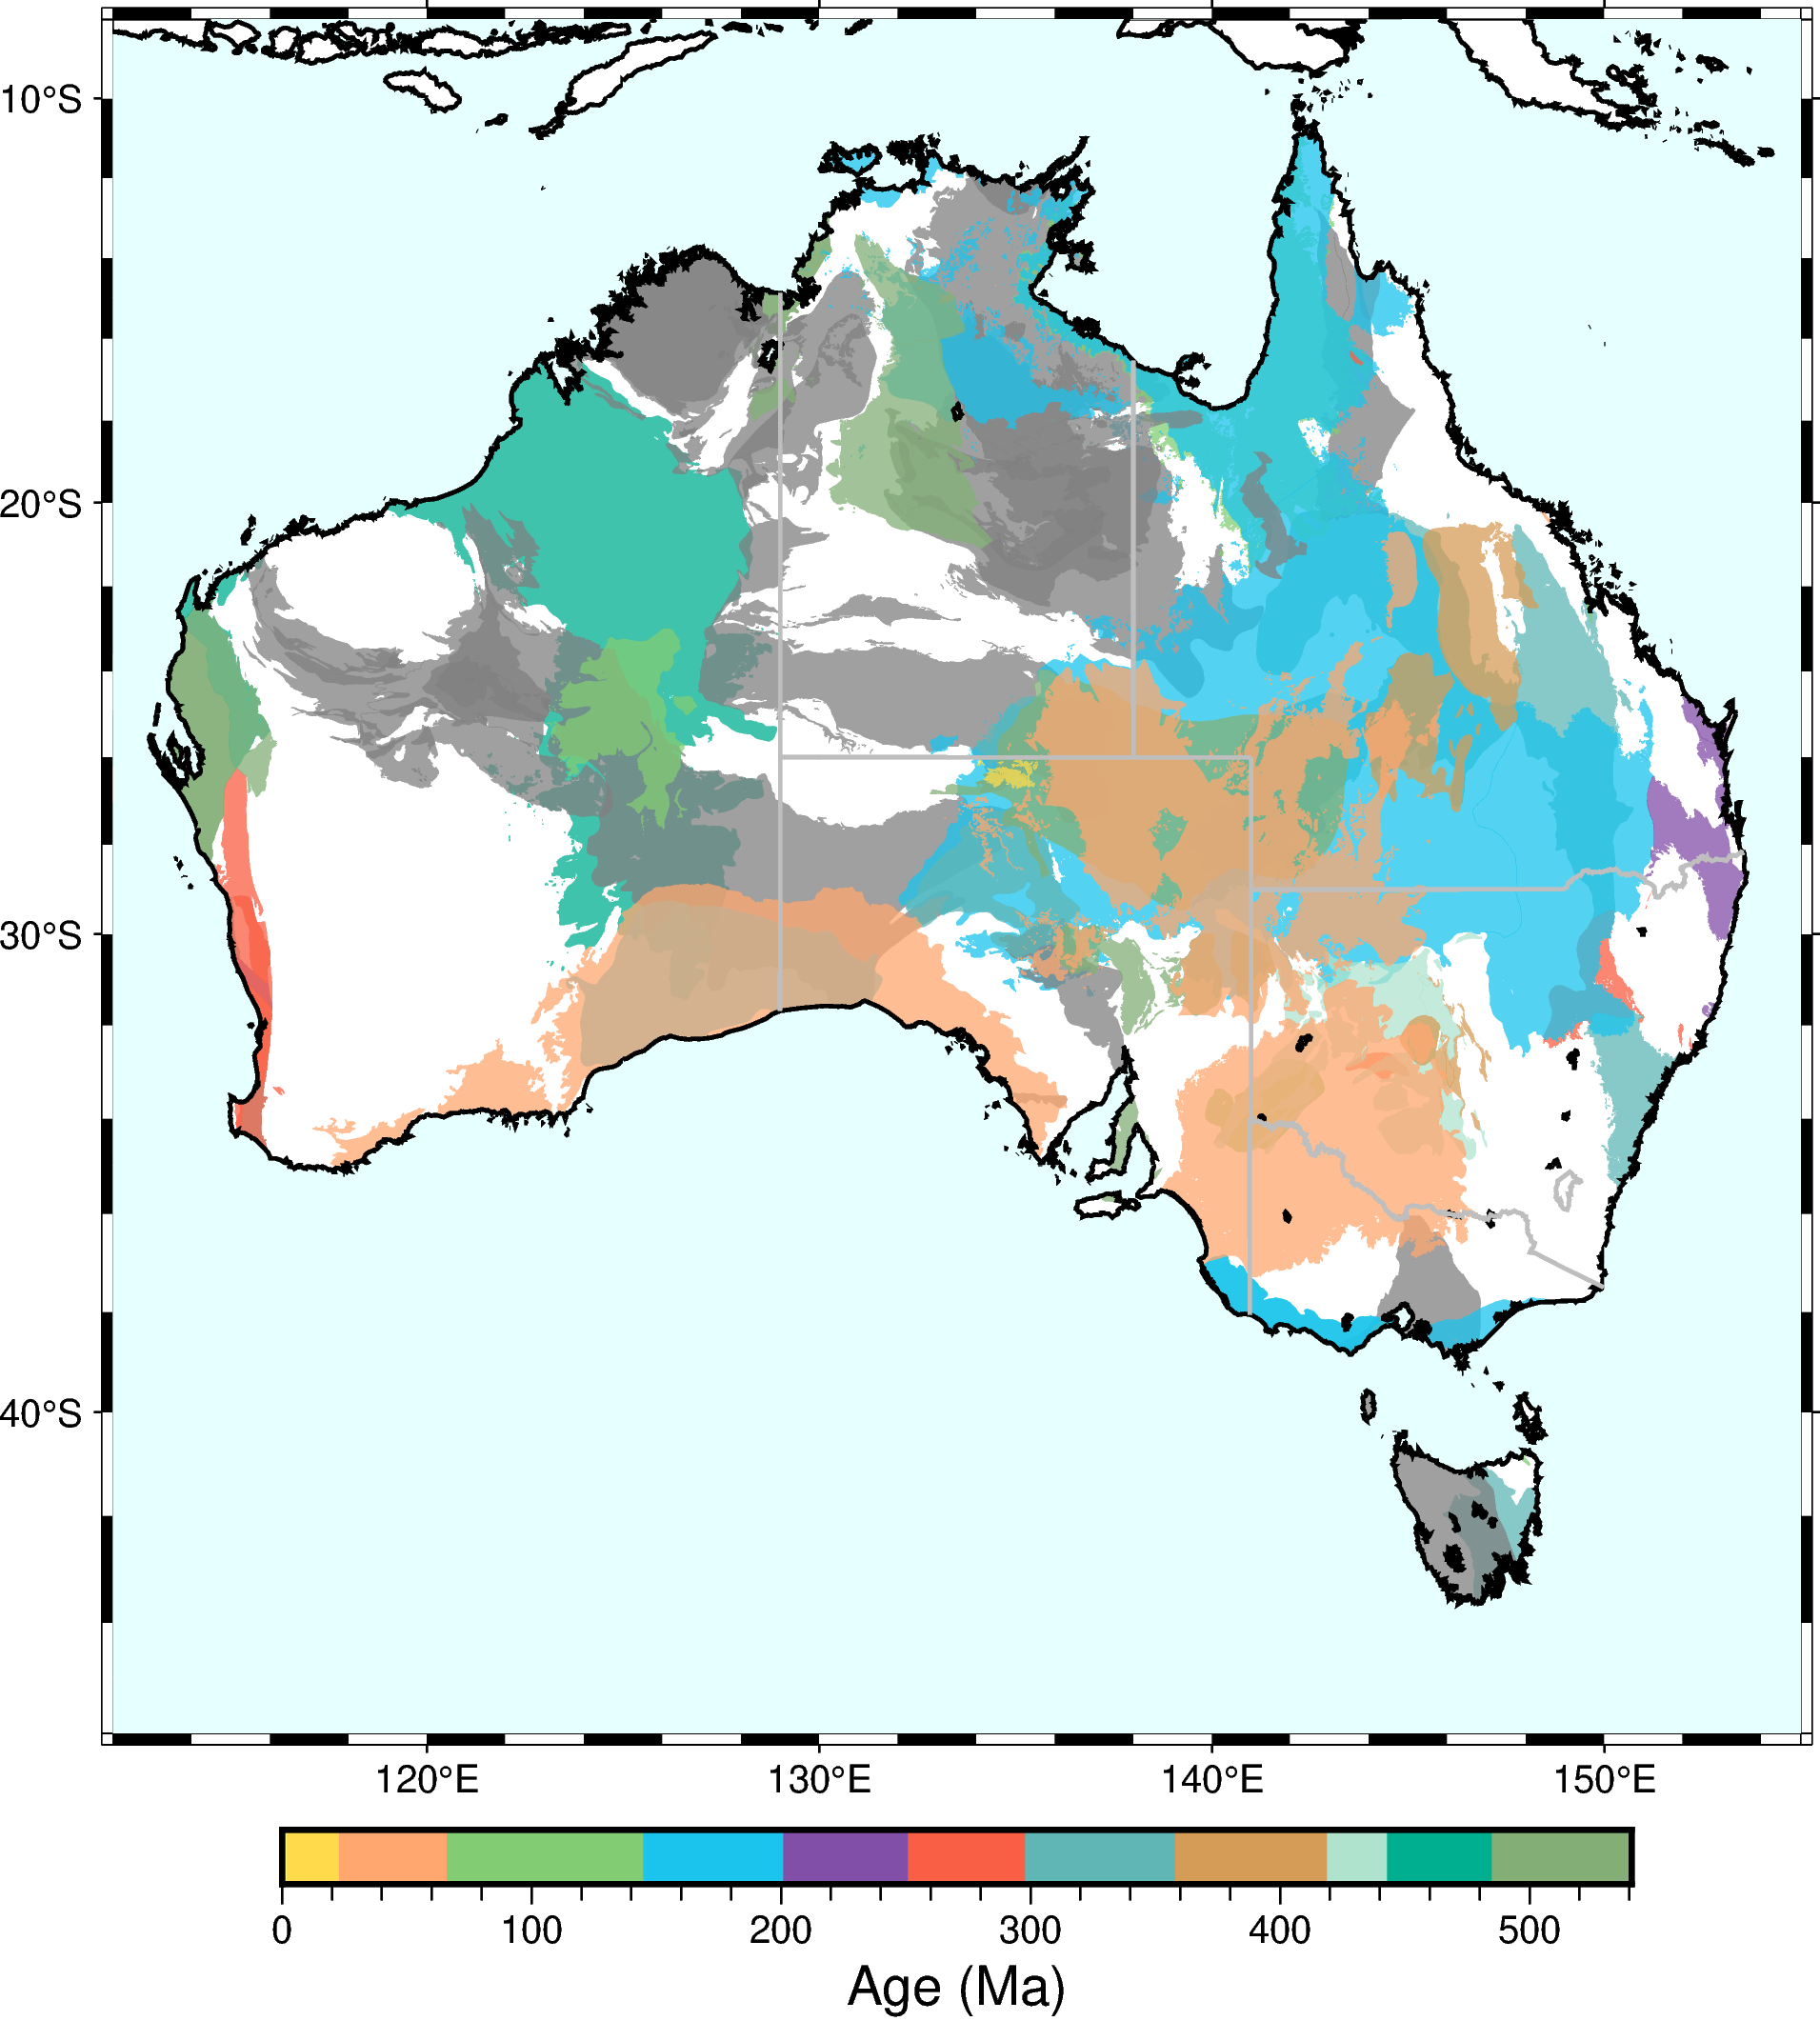

In [3]:
fig = pygmt.Figure()
fig_width = 15
region=[112, 155, -46, -8]
ln_min, ln_max, lt_min, lt_max = region
projection = f"M{int(np.mean([ln_min, ln_max]))}/{int(np.mean([lt_min, lt_max]))}/{fig_width}c"
fig.basemap(region=region, projection=projection, frame=True)
for i, polygon in gdf[::-1].iterrows():  # [::-1] flips the df to plot the oldest first
    # pygmt doesn't seem to have a nice way of colouring polygons
    # from a GeoDataFrame using a column to map to colours
    # so loop through and select the fill
    # Have to wrap each polygon into its own GeoDataFrame
    df = gpd.GeoDataFrame([polygon])
    fill = df["fill"].iloc[0]
    fig.plot(data=df, region=region, projection=projection, fill=fill, transparency=25)
fig.coast(
    region=region,
    projection=projection,
    shorelines=1,
    resolution="i",
    water="#e6ffff",
    borders="2/1p,grey",
)
fig.colorbar(region=region, projection=projection, cmap="data/geological_timescale/geological_timeline.cpt", frame=["af+lAge (Ma)",])
    
fig.show()